# Input Parameters

In [54]:
#source ISvenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#ISvenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate - to deactivate the virtual environment

#import all the libraries needed
from import_dep import *

# import the class that imports the IS data
from IS_Import import ISdata, ImpedanceData, AgilentIS, SolatronIS
from IS_Functions import IS_plot, IS_plot_fit, run_to_dict, update_plot_string, add_slide, extract_single_dc
from IS_Circuit_Fitting import *
from IS_Debye_Fitting import *


# import custom plot style and colorbar functions
from plot_style import set_plot_style

# Define the path to the root directory containing the IS Data 
root_IS_Agilent = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Groningen'
root_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis'

# Define the path to the output directory to save the data
output_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis/Output/'

# Export settings
fig_format = 'svg' # format of the figure to be saved
plot_transparency = True # set to True to export plots with transparency
export_data = True # set to True to export the data to figures and a powerpoint presentation and save to path_out
powerpoint_string = 'run113v115' # string added to end of powerpoint filename
fig_list = [] # Create a list to flexibly store tuples with the (figure, filename, title) for later exporting


# Custom Scence style settings for figures which returns a figure size to pass to plotting functions if needed
fig_size = set_plot_style(export_data = export_data, use_tex=True)
#plt.style.use(['science', 'grid', 'nature'])




# Capacitance Approximations

In [55]:
e = scipy.constants.epsilon_0  # epsilon_0 constant in F/m (Farads per meter)
C_calc_siox = (e*4*(20e-6)**2)/(25e-9)
print("C_siox", C_calc_siox)
pad_area = (40000+1719.0-12.5)*1e-12
C_calc_pad = (e*7*pad_area)/((110+25)*1e-9) 
print("C_pad", C_calc_pad)

print("formed",(8.854e-12*40*(20e-6)**2)/(1e-9) )

print("C_TiO2",(8.854e-12*80*(20e-6)**2)/(1e-9) )



C_siox 5.666680204032001e-13
C_pad 1.9147705850766482e-11
formed 1.4166400000000001e-10
C_TiO2 2.8332800000000003e-10


# Import All Data
- This stores a class object which contains the data in "measurements"
- "measurements" is a dictionary with a key: and a ISdata object containing impedance data
- e.g. print(dev_J.measurements.keys())
- measurements is an iter object so "for measurements in dev_J" loops over the ISdata objects in the dict
- measurements also has a __getitem__ meaning that dev_J[0] indexes the first item in the dict (the first ISdata object)

- Here I am using run_to_dict to put all data into a dict where dict[6] contains a list of all the run 6 data

In [56]:
%%capture
#import all solatron data from combined folder
all_data_solatron = SolatronIS(root_IS_solatron, 'All_data')

# loop through the imported data and put all measurements with the same run number into a list
# With each list containing the data for a single run put into a dictionary
solatron = run_to_dict(all_data_solatron)

### DC Offset Causing Instability in Memristive State
- Run 5: DC = -1:0.1:1, 50mV AC, 32MHz, Ambient
- NOTE: this is BEFORE the Au contact issue was realised

# Pristine

In [57]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': False,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e11, 1e14), 'C_mem1': (1e-12, 5e-10),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']


# --- Select Data ---
# Select data 
d69  = solatron[69]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)

for dat in d69:
    # --- Run Fit ---
    fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=69, DC=0.0, V_rms=0.04722223, p, ambient, amp, wirebond6 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
420 pts post-freq filter.
Median filter k=5
Auto-generating intelligent initial guess for LS...
Using auto-generated initial guess for LS: {'R_mem1': 100000000000.0, 'C_mem1': 5e-10, 'R_series': np.float64(313.249577787119)}

Running LS Refinement...
LS OK!
  LS Final Cost: 5.6201e+00
  Final Fitted Parameters:
    R_mem1: 2.3123e+11
    C_mem1: 1.6608e-11
    C_pad: 1.9148e-11
    R_series: 2.9964e+02
--- Fit finished for: run=69, DC=0.0, V_rms=0.04722223, p, ambient, amp, wirebond6 ---

--- Starting Fit for: run=69, DC=-0.1, V_rms=0.04722223, p, ambient, amp, wirebond6 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
420 pts po

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


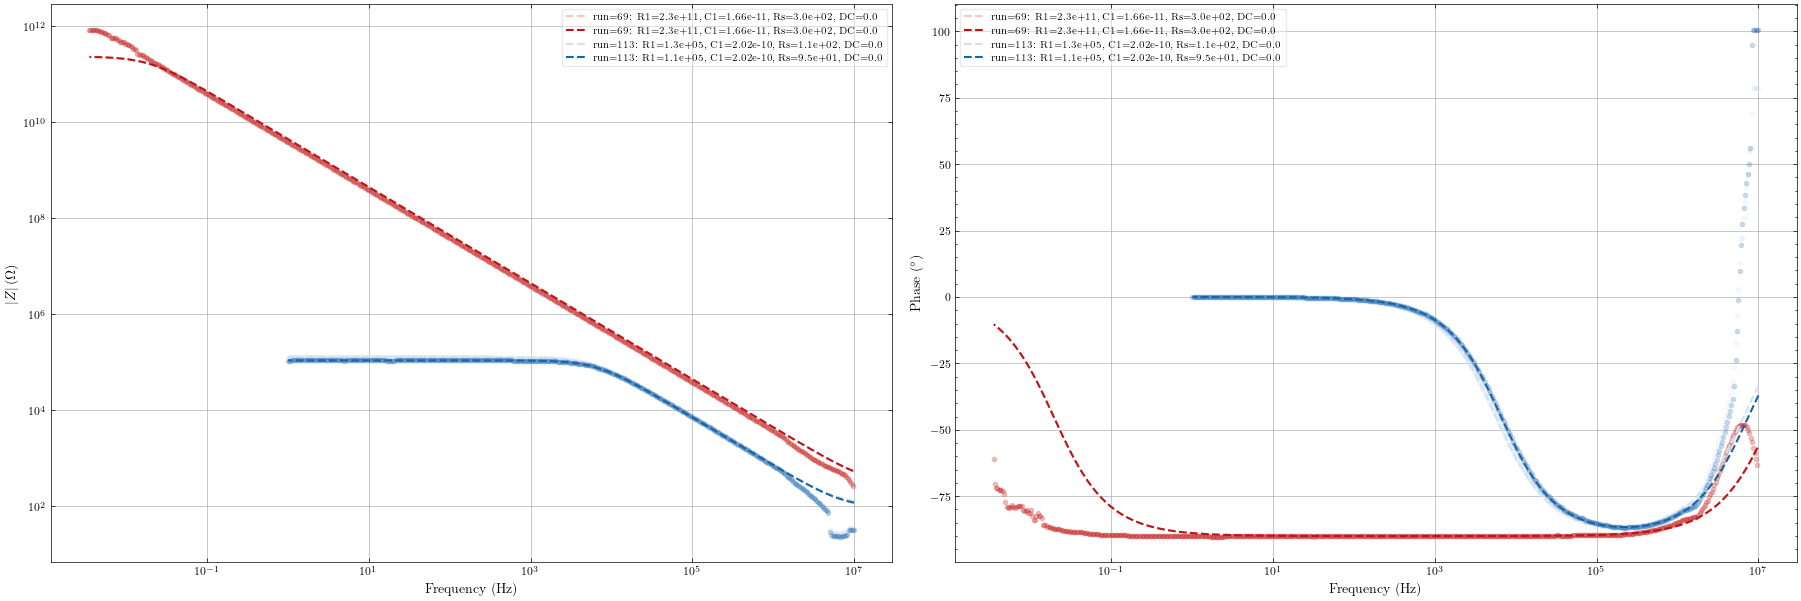

In [76]:
# ---------------------------------------- Plotting the Fitting ------------------------------    

d69  = [[solatron[69][0],solatron[69][0]], [solatron[113][2],solatron[113][6]]]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'PristineComparisonwkey' # name for exported figure
plot_title = 'Pristine Comparison' # title for powerpoint

# Notes
notes = ['When electroforming, resistance goes from 2e11 to 1e5', 'Capacitance increases from 2e-11 to 2e-10', 'C_siox=5.6e-13','C_pad 1.9e-11', '1nm of TiO2 gives C_tio2 = 2.8e-10' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9,6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

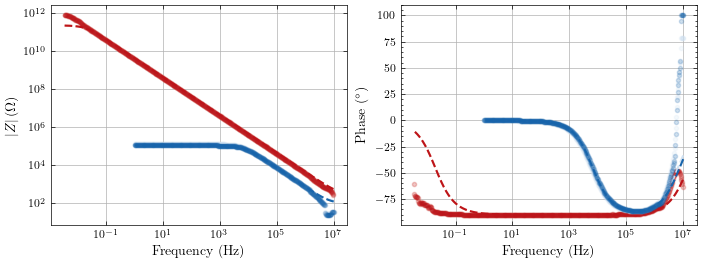

In [77]:
# ---------------------------------------- Plotting the Fitting ------------------------------    

d69  = [[solatron[69][0],solatron[69][0]], [solatron[113][2],solatron[113][6]]]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'PristineComparisonnokey' # name for exported figure
plot_title = 'Pristine Comparison' # title for powerpoint

# Notes
notes = ['When electroforming, resistance goes from 2e11 to 1e5', 'Capacitance increases from 2e-11 to 2e-10', 'C_siox=5.6e-13','C_pad 1.9e-11', '1nm of TiO2 gives C_tio2 = 2.8e-10' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# All Data

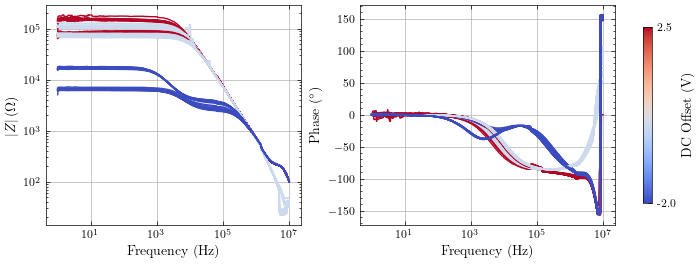

In [78]:
# Select data 
# ---------------------------------------- Plotting the Fitting ------------------------------
# Section off the Vacuum Data
d_vac_set_test = solatron[113][0::4]
d_vac_reset = solatron[113][1::4]
d_vac_reset_test = solatron[113][2::4]
d_vac_set = solatron[113][3::4]

# Section off the Ambient Data
d_amb_set_test = solatron[115][0::4]
d_amb_reset = solatron[115][1::4]
d_amb_reset_test = solatron[115][2::4]
d_amb_set = solatron[115][3::4]
    
d = [d_vac_set_test[1:]+ d_vac_reset+ d_vac_reset_test+ d_vac_set+ d_amb_set_test+ d_amb_reset+ d_amb_reset_test+ d_amb_set]
# extract a single DC level from the data
#d = extract_single_dc(d, DC_val=0)

# Labels
#plot_labels = ['wb5, formed, vacuum', 'wb5, formed, ambient-failed', 'wb5, formed, ambient'] # label for the legend
plot_filename = 'AmbientVacuumOverall' # name for exported figure
plot_title = 'Switching Device with DC Offset in Vacuum and Ambient' # title for powerpoint

# Notes
notes = ['All runs use a loop [0, 2.5V, 0, -2V] to measure state then switch ON/OFF then measure state'
        'Vacuum was left at 9e-7 for 3 days before starting the run',
         'First ambient run was started after 7 hours at ambient but crashed part way through',
         'Second ambient run was started 2 days after the vacuum and completed successfully',
         ] # notes for the powerpoint in text box

# if export true, update the plot string
#d = update_plot_string(d, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 9, force_key = False, show_key=False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# SET STATE

In [79]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC2', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_set, d_amb_set]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.1045e-01
  DE Best:)
name R_mem1: 3.56e+03
name C_mem1: 1.00e-08
name R_mem2: 3.50e+03
name C_mem2: 2.36e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.0991e-01
  Final Fitted Parameters:
    R_mem1: 3.5600e+03
    C_mem1: 9.9000e-09
    R_mem2: 3.5024e+03
    C_mem2: 2.3579e-10
    C_pad: 1.9148e-11
    R_series: 1.0000e+00
--- Fit finished for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: 

### SET - vac v amb

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


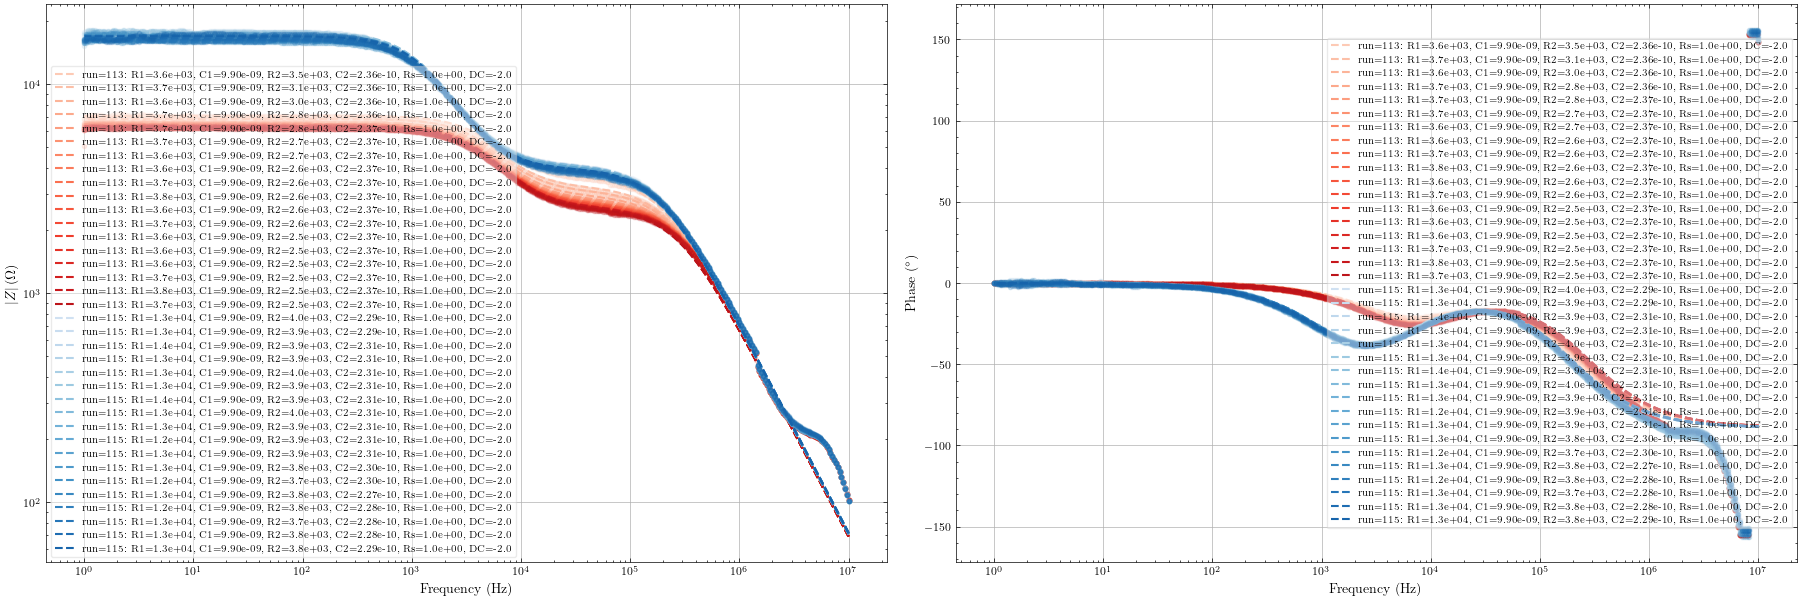

In [80]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacwithkey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

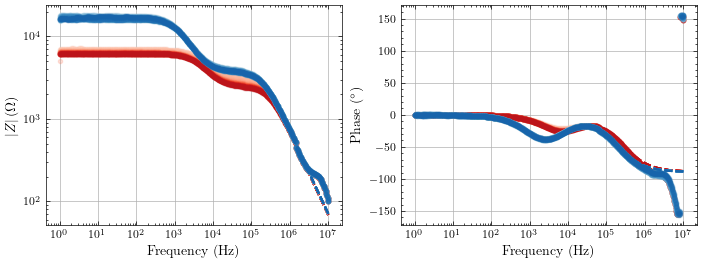

In [81]:

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacnokey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# Set TEST

In [82]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_set_test, d_amb_set_test]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 1.4887e+02
  DE Best:)
name R_mem1: 4.60e+05
name C_mem1: 1.00e-10
name R_series: 1.00e+04

Running LS Refinement...
LS OK!
  LS Final Cost: 7.4435e+01
  Final Fitted Parameters:
    R_mem1: 4.5999e+05
    C_mem1: 1.0000e-10
    C_pad: 1.9148e-11
    R_series: 1.0000e+04
--- Fit finished for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 6

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


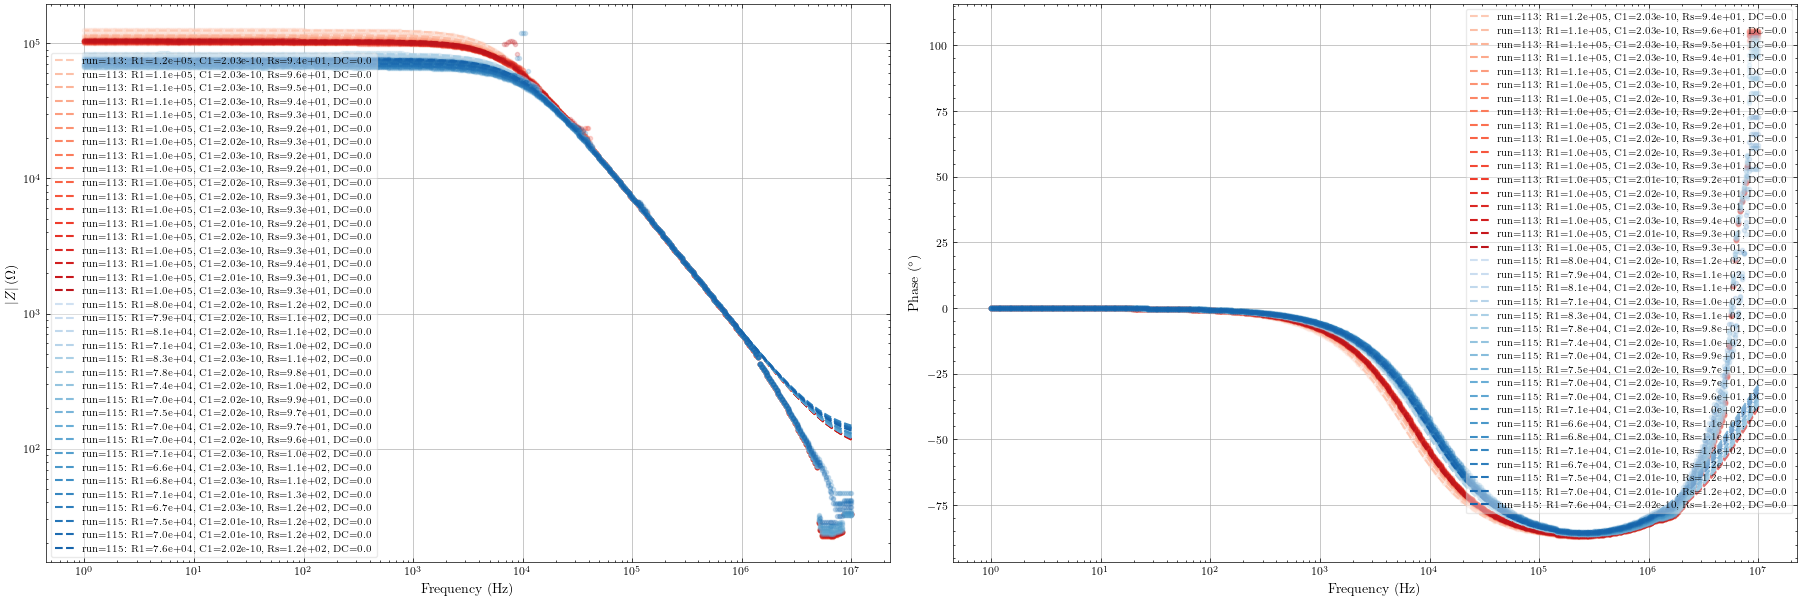

In [83]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set_test[1:], d_amb_set_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsettestambvacwithkey' # name for exported figure
plot_title = 'DC = 0V, post SET(-2V) Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'single RC model', 'Lower resistivity in ambient', 'Very similar capacitance for both'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

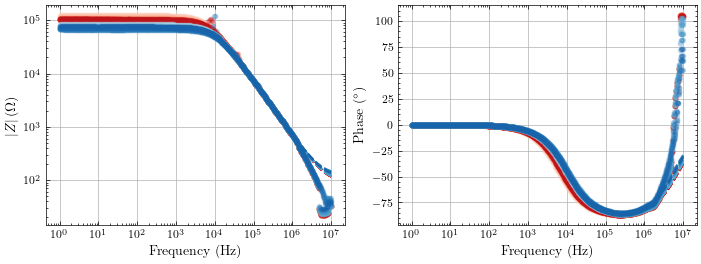

In [ ]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set_test[1:], d_amb_set_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsettestambvacnokey' # name for exported figure
plot_title = 'DC = 0V, post SET(-2V) Ambient vs Vacuum without Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'single RC model', 'Lower resistivity in ambient', 'Very similar capacitance for both'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# RESET

In [85]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_reset, d_amb_reset]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.2713e-01
  DE Best:)
name R_mem1: 1.75e+05
name C_mem1: 2.01e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 2.1357e-01
  Final Fitted Parameters:
    R_mem1: 1.7504e+05
    C_mem1: 2.0093e-10
    C_pad: 1.9148e-11
    R_series: 1.0000e+00
--- Fit finished for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


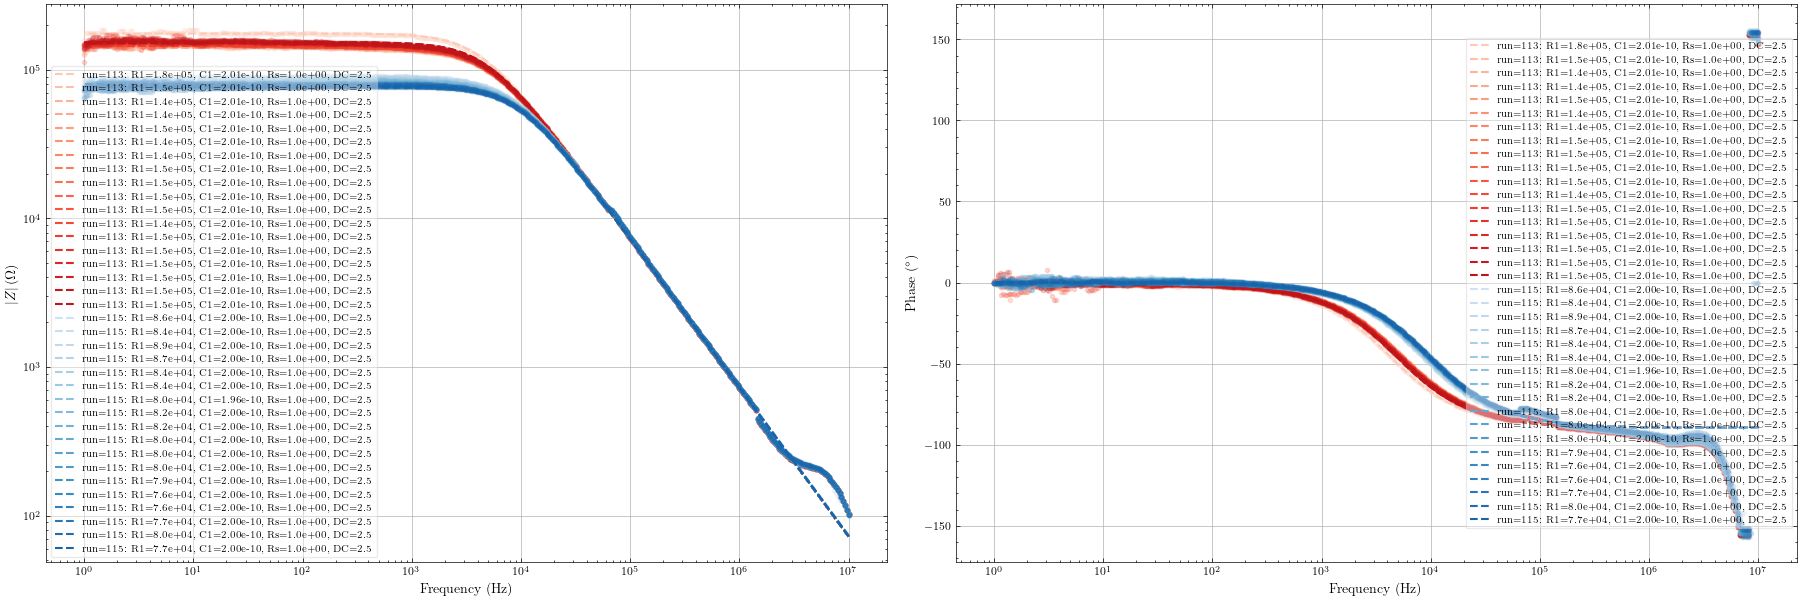

In [86]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset, d_amb_reset]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresetambvackey' # name for exported figure
plot_title = 'DC = 2.5V Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Very slightly lower capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

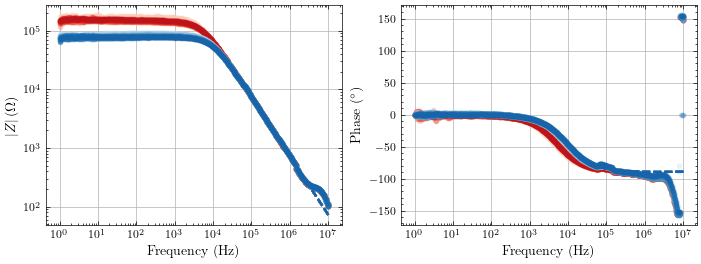

In [87]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset, d_amb_reset]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresetambvackeynokey' # name for exported figure
plot_title = 'DC = 2.5V Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Very slightly lower capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# RESET TEST

In [88]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_reset_test, d_amb_reset_test]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.3852e-02
  DE Best:)
name R_mem1: 1.27e+05
name C_mem1: 2.02e-10
name R_series: 1.09e+02

Running LS Refinement...
LS OK!
  LS Final Cost: 2.1926e-02
  Final Fitted Parameters:
    R_mem1: 1.2706e+05
    C_mem1: 2.0247e-10
    C_pad: 1.9148e-11
    R_series: 1.0857e+02
--- Fit finished for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3

/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/horatiocox/Desktop/IS_Analysis/ISvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


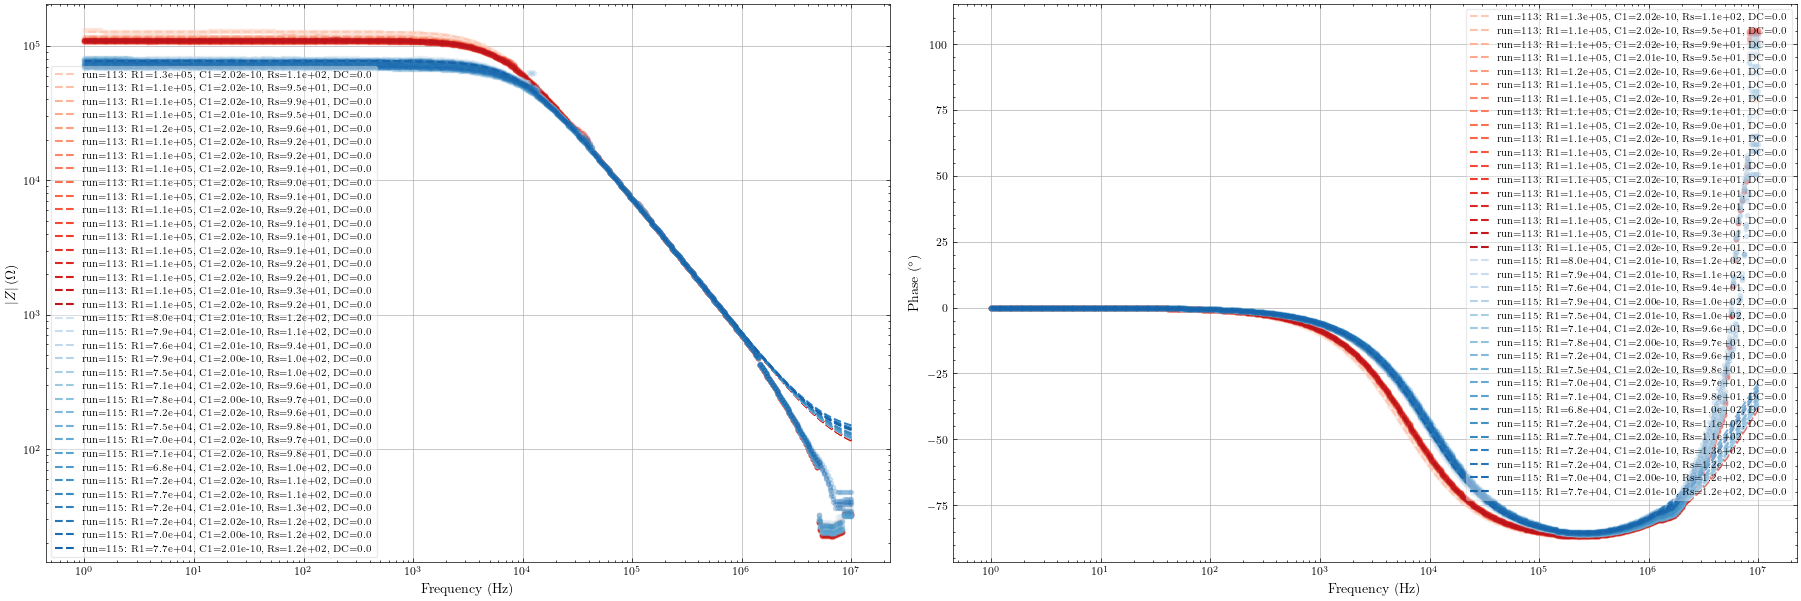

In [89]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset_test, d_amb_reset_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresettestambvackeykey' # name for exported figure
plot_title = 'DC = 0V Post RESET (2.5V) Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Identical capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9,6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

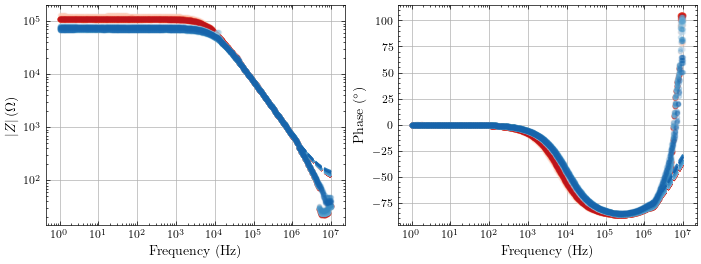

In [90]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset_test, d_amb_reset_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresettestambvacnokey' # name for exported figure
plot_title = 'DC = 0V Post RESET (2.5V) Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Identical capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

In [91]:
25e-9/((20e-6)**2 *2.46e-4)
print( 9e-9 *25e-9/((20e-6)**2 *epsilon_0))

63529.25999668198


# Exporting

### Exporting All Figures as Individual Files

In [92]:
if export_data:
    for fig_obj, fig_name, fig_title, notes in fig_list:
        save_path = Path(output_IS_solatron) / Path(f"{fig_name}_{powerpoint_string}.{fig_format}")
        fig_obj.savefig(save_path, dpi=600, bbox_inches='tight', transparent=plot_transparency)

### Exporting to Powerpoint

In [93]:
if export_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()

   

    # define the path to the output directory
    path_out = output_IS_solatron

    # Add each figure to the PowerPoint presentation if it exists
    for fig, fig_name, title, notes in fig_list:
        add_slide(fig, title, notes, prs, path_out = path_out)

    # Save the PowerPoint presentation
    prs.save(Path(path_out) / Path(f'{powerpoint_string}.pptx'))

Added slide: Pristine Comparison
Added slide: Pristine Comparison
Added slide: Switching Device with DC Offset in Vacuum and Ambient
Added slide: DC = -2V Ambient vs Vacuum with Key
Added slide: DC = -2V Ambient vs Vacuum with Key
Added slide: DC = 0V, post SET(-2V) Ambient vs Vacuum with Key
Added slide: DC = 0V, post SET(-2V) Ambient vs Vacuum without Key
Added slide: DC = 2.5V Ambient vs Vacuum
Added slide: DC = 2.5V Ambient vs Vacuum
Added slide: DC = 0V Post RESET (2.5V) Ambient vs Vacuum
Added slide: DC = 0V Post RESET (2.5V) Ambient vs Vacuum
Added slide: Pristine Comparison
Added slide: Pristine Comparison
Added slide: Switching Device with DC Offset in Vacuum and Ambient
Added slide: DC = -2V Ambient vs Vacuum with Key
Added slide: DC = -2V Ambient vs Vacuum with Key
Added slide: DC = 0V, post SET(-2V) Ambient vs Vacuum with Key
Added slide: DC = 0V, post SET(-2V) Ambient vs Vacuum without Key
Added slide: DC = 2.5V Ambient vs Vacuum
Added slide: DC = 2.5V Ambient vs Vacuum
Ad